In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from VAE_model import TFVariationalAutoencoder
import pandas as pd
import random

In [2]:
np.random.seed(10)

# select data

In [3]:
# select data source:
# can be "mill" or "X"
data_source = "X"

# select corruption level:
# can be "light" or "heavy"
corr_level = "light"

# Path to uncorrupted data:
DataPath = "./data/" + data_source + "data.csv"
# Path to corrupted data:
CorruptDataPath ="./data/"+ data_source + "datacorrupt" + corr_level + ".csv"


# load data

In [4]:
# Load data from a csv for analysis:
Xdata_df = pd.read_csv(DataPath)
Xdata = Xdata_df.values
del Xdata_df

# Load data with missing values from a csv for analysis:
Xdata_df = pd.read_csv(CorruptDataPath)
Xdata_Missing = Xdata_df.values
del Xdata_df


# plot data distribution for small datasets

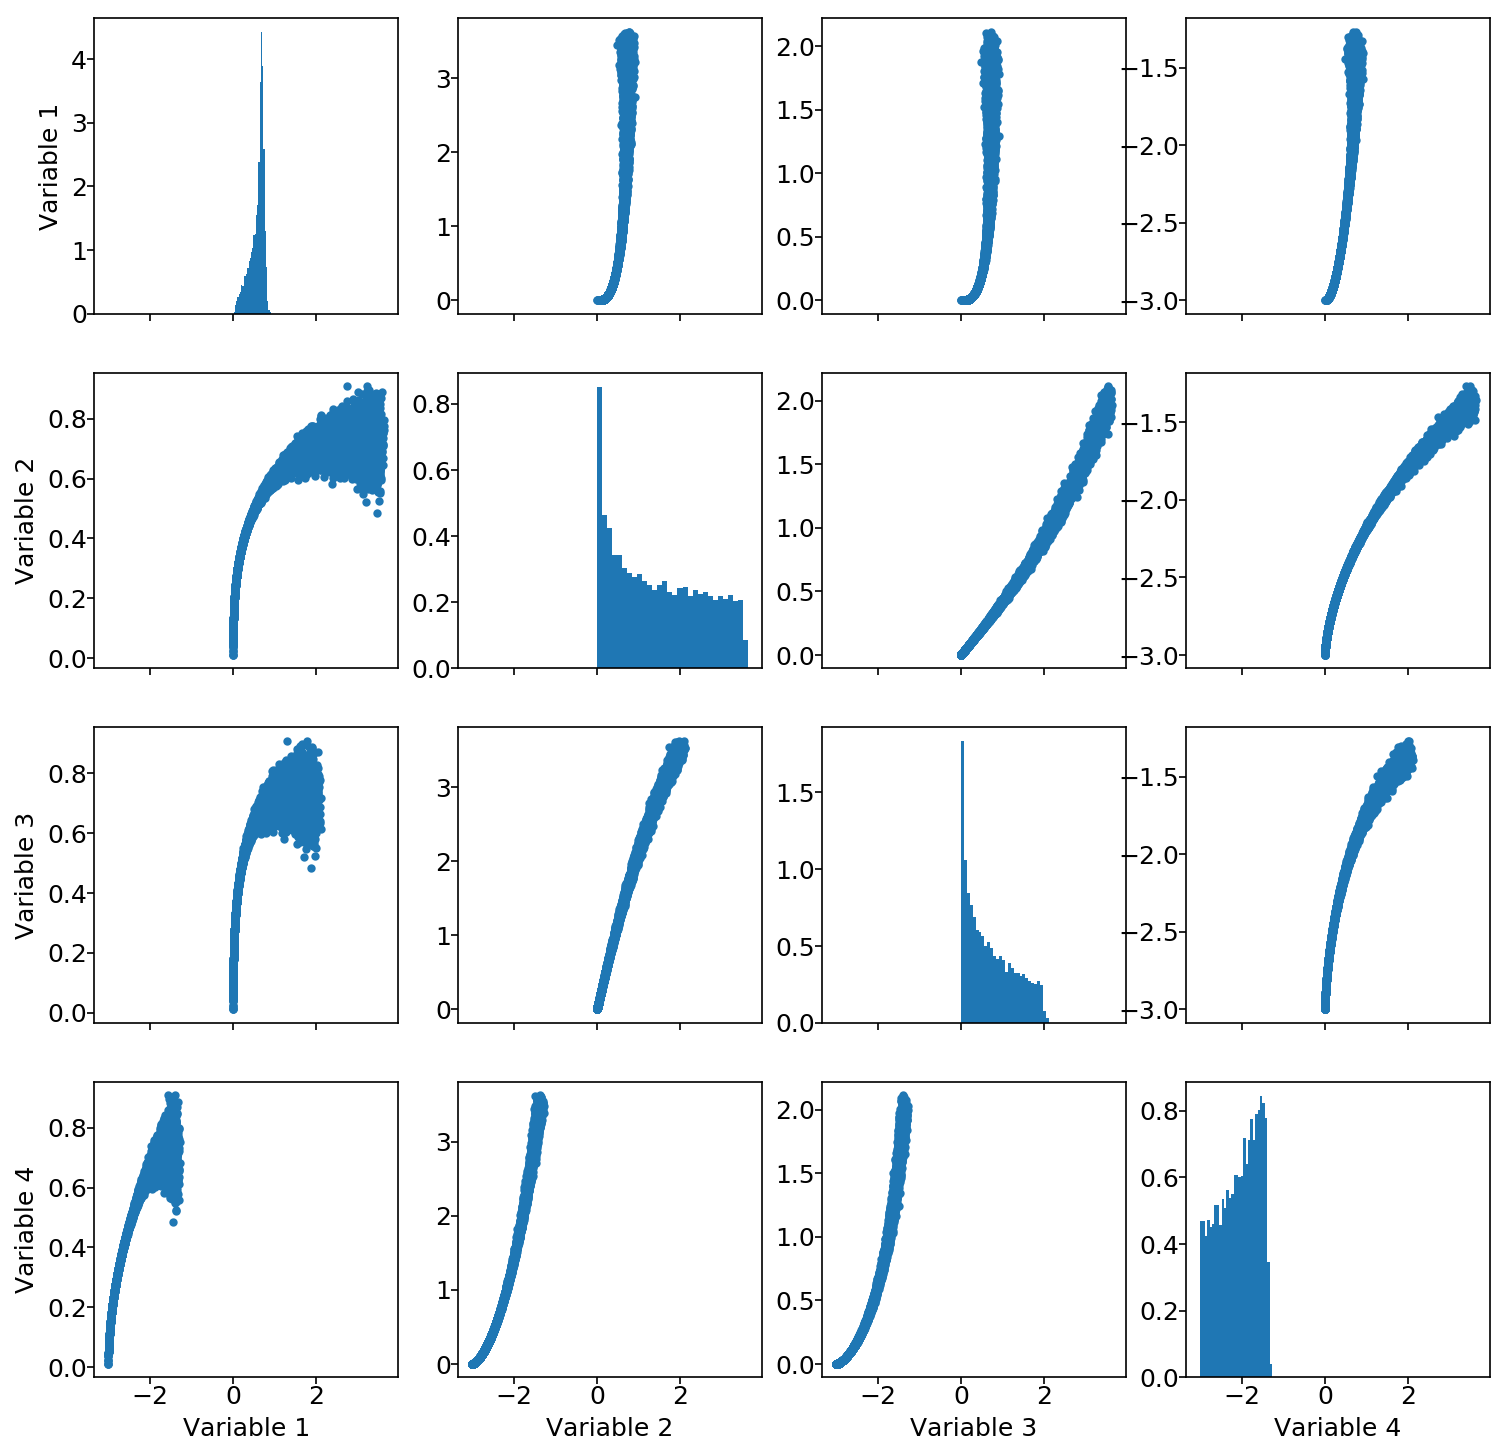

In [5]:
subplotmax = Xdata.shape[1]
f, axarr = plt.subplots(subplotmax, subplotmax, sharex='col', dpi = 150,figsize=(15, 15))
#f.suptitle( data_source +' data distribution', fontsize=12)
for k in range(subplotmax):
    for j in range(subplotmax):
        if k == j:
            axarr[k, j].hist(Xdata[:,k],bins = 30, density=True)
            #axarr[k, j].hist(x_hat[:,k],bins = 30, alpha = 0.7, density=True)
            axarr[k, j].tick_params(labelsize='large', pad = 0)
            if j == 0:
                axarr[k, j].set_ylabel('Variable 1', fontsize=12)
            elif j == subplotmax-1:
                axarr[k, j].set_xlabel('Variable ' + str(subplotmax), fontsize=12)
        else:
            axarr[k, j].plot(Xdata[:,k], Xdata[:,j], '.',label = 'Data')
            #axarr[k, j].plot(x_hat[:,k], x_hat[:,j], '+', alpha = 0.2, label='Posterior')
            axarr[k, j].tick_params(labelsize='large', pad = 0)
            if j == 0:
                axarr[k, j].set_ylabel('Variable ' + str(k+1), fontsize=12)
            if k == subplotmax-1:
                axarr[k, j].set_xlabel('Variable ' + str(j+1), fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12, 12)
#fig.savefig('posterior_light_corrupted.png', dpi=100)



# seperate complete and missing data

In [6]:
# Properties of data:
Xdata_length = Xdata_Missing.shape[0] # number of data points to use
n_x = Xdata_Missing.shape[1] # dimensionality of data space
ObsRowInd = np.where(np.isfinite(np.sum(Xdata_Missing,axis=1)))
NanRowInd = np.where(np.isnan(np.sum(Xdata_Missing,axis=1))) 
NanIndex = np.where(np.isnan(Xdata_Missing))
Xdata_Missing_Rows = NanRowInd[0] # number of rows with missing values

# Number of missing values
NanCount = len(NanIndex[0])

# standardise data

In [7]:
# Zscore for reconstruction error checking:
scRecon = StandardScaler()
#standardise using ground true data
scRecon.fit(Xdata)

# Zscore of data produces much better results
sc = StandardScaler()
Xdata_Missing_complete = np.copy(Xdata_Missing[ObsRowInd[0],:])
# standardise using complete records:
sc.fit(Xdata_Missing_complete)

Xdata_Missing[NanIndex] = 0 #feed the nan with 0
Xdata_Missing = sc.transform(Xdata_Missing) #standardised data after corrputed data replaced by mean 0 
Xdata_Missing[NanIndex] = np.nan #feed back the nan
#now all points in the missing data is standardised 
#according to the observed data
Xdata = sc.transform(Xdata)
del Xdata_Missing_complete

x_test_true = Xdata[NanRowInd]



# corrupt training data 

In [8]:
#with a given missrate of total rows
#for each row randomly seltect 1 feature to corrput
missrate = 0.2

X_train = np.copy(Xdata_Missing)
Xtrain_complete = np.copy(X_train[ObsRowInd[0],:])

misssize = int(Xtrain_complete.shape[0] * missrate)

#random select the data points to corrupt 
#replace = False no rows were select twice
rowidx = np.random.choice(range(Xtrain_complete.shape[0]), size=misssize, replace=False)
#replace=true, features can be reselecet for different rows
colidx = np.random.choice(range(Xtrain_complete.shape[1]), size=misssize, replace=True)

#replace the real value with 0 mean replace to mimick the test data corruption
Xtrain_complete[rowidx, colidx] = 0

X_train[ObsRowInd[0],:] = Xtrain_complete
#print(X_train)




[[ 0.70236786  1.36811489  1.3959629   1.12035342]
 [ 1.09673841  0.35406892  0.19980925  0.52840738]
 [        nan -1.09087567 -1.01891514 -1.10264012]
 ...
 [-0.96914772 -1.10415018 -1.03229727 -1.13433184]
 [-0.86871681         nan -1.00521935 -1.05399249]
 [ 0.85606646  1.21691074  1.17654816  1.21698401]]


# Initialize and train VAE

In [9]:
# VAE network Architecture:

hidden_layer_size =[8,16,4,16,8]

Decoder_hidden1 = hidden_layer_size[0]
Decoder_hidden2 = hidden_layer_size[1]
# dimensionality of latent space:
latent_size = hidden_layer_size[2]
Encoder_hidden1 = hidden_layer_size[3]
Encoder_hidden2 = hidden_layer_size[4]


# training parameters:
training_epochs_list = [100, 200, 500, 1000, 2000, 5000, 10000]
training_epochs = training_epochs_list[3]

batch_size_list=[32,64,128,256]
batch_size = batch_size_list[0]

lr_list = [1e-5, 1e-4,3e-4,1e-3,1e-2]
learning_rate = lr_list[3]

# specify number of imputation iterations:
ImputeIter = 25


In [10]:
# define dict for network structure:
network_architecture = dict(n_hidden_recog_1=Encoder_hidden1, # 1st layer encoder neurons
         n_hidden_recog_2=Encoder_hidden2, # 2nd layer encoder neurons
         n_hidden_gener_1=Decoder_hidden1, # 1st layer decoder neurons
         n_hidden_gener_2=Decoder_hidden2, # 2nd layer decoder neurons
         n_input=n_x, # data input size
         n_z=latent_size)  # dimensionality of latent space



# initialise VAE:

In [11]:
# initialise VAE:
vae = TFVariationalAutoencoder(network_architecture, 
                             learning_rate=learning_rate, 
                             batch_size=batch_size)

In [12]:
#Xtest data prepare
X_corrupt = np.copy(Xdata_Missing)
NanRowIndex = np.where(np.isnan(np.sum(X_corrupt,axis=1)))
x_miss_val = X_corrupt[NanRowIndex[0],:]
        
# initialise missing values with arbitrary value
NanIndex = np.where(np.isnan(x_miss_val))
x_miss_val[NanIndex] = 0

In [14]:

# train VAE on corrupted data:
vae = vae.train(XData=X_train, X_true=Xdata_Missing, Xtest=np.asarray(x_miss_val, np.float32),
                     Xtest_true=x_test_true, 
                training_epochs=training_epochs,display_step=1)

Epoch 1 | Cost= 5.814 |test error=0.968
Epoch 2 | Cost= 5.185 |test error=0.695
Epoch 3 | Cost= 4.293 |test error=0.560
Epoch 4 | Cost= 3.784 |test error=0.478
Epoch 5 | Cost= 3.231 |test error=0.398
Epoch 6 | Cost= 2.487 |test error=0.306
Epoch 7 | Cost= 1.779 |test error=0.266
Epoch 8 | Cost= 1.211 |test error=0.225
Epoch 9 | Cost= 0.688 |test error=0.189
Epoch 10 | Cost= 0.082 |test error=0.168
Epoch 11 | Cost= -0.448 |test error=0.146
Epoch 12 | Cost= -0.917 |test error=0.133
Epoch 13 | Cost= -1.275 |test error=0.124
Epoch 14 | Cost= -1.572 |test error=0.120
Epoch 15 | Cost= -1.813 |test error=0.117
Epoch 16 | Cost= -1.907 |test error=0.115
Epoch 17 | Cost= -1.975 |test error=0.112
Epoch 18 | Cost= -2.006 |test error=0.119
Epoch 19 | Cost= -2.072 |test error=0.110
Epoch 20 | Cost= -2.160 |test error=0.109
Epoch 21 | Cost= -2.184 |test error=0.110
Epoch 22 | Cost= -2.185 |test error=0.116
Epoch 23 | Cost= -2.219 |test error=0.108
Epoch 24 | Cost= -2.270 |test error=0.107
Epoch 25 | 

Epoch 195 | Cost= -2.912 |test error=0.107
Epoch 196 | Cost= -2.925 |test error=0.103
Epoch 197 | Cost= -2.900 |test error=0.104
Epoch 198 | Cost= -2.925 |test error=0.101
Epoch 199 | Cost= -2.921 |test error=0.102
Epoch 200 | Cost= -2.903 |test error=0.101
Epoch 201 | Cost= -2.957 |test error=0.102
Epoch 202 | Cost= -2.951 |test error=0.101
Epoch 203 | Cost= -2.894 |test error=0.102
Epoch 204 | Cost= -2.991 |test error=0.101
Epoch 205 | Cost= -2.889 |test error=0.104
Epoch 206 | Cost= -2.903 |test error=0.101
Epoch 207 | Cost= -2.951 |test error=0.100
Epoch 208 | Cost= -2.895 |test error=0.100
Epoch 209 | Cost= -2.920 |test error=0.104
Epoch 210 | Cost= -2.941 |test error=0.105
Epoch 211 | Cost= -2.921 |test error=0.101
Epoch 212 | Cost= -2.901 |test error=0.101
Epoch 213 | Cost= -2.933 |test error=0.101
Epoch 214 | Cost= -2.940 |test error=0.100
Epoch 215 | Cost= -2.913 |test error=0.102
Epoch 216 | Cost= -2.937 |test error=0.102
Epoch 217 | Cost= -2.925 |test error=0.101
Epoch 218 |

Epoch 386 | Cost= -3.142 |test error=0.104
Epoch 387 | Cost= -3.057 |test error=0.103
Epoch 388 | Cost= -3.139 |test error=0.103
Epoch 389 | Cost= -3.155 |test error=0.101
Epoch 390 | Cost= -3.100 |test error=0.100
Epoch 391 | Cost= -3.079 |test error=0.103
Epoch 392 | Cost= -3.134 |test error=0.104
Epoch 393 | Cost= -3.152 |test error=0.100
Epoch 394 | Cost= -3.091 |test error=0.100
Epoch 395 | Cost= -3.102 |test error=0.100
Epoch 396 | Cost= -3.043 |test error=0.100
Epoch 397 | Cost= -3.064 |test error=0.100
Epoch 398 | Cost= -3.104 |test error=0.100
Epoch 399 | Cost= -3.113 |test error=0.102
Epoch 400 | Cost= -3.065 |test error=0.103
Epoch 401 | Cost= -3.160 |test error=0.102
Epoch 402 | Cost= -3.128 |test error=0.100
Epoch 403 | Cost= -3.119 |test error=0.102
Epoch 404 | Cost= -3.109 |test error=0.100
Epoch 405 | Cost= -3.090 |test error=0.100
Epoch 406 | Cost= -3.145 |test error=0.105
Epoch 407 | Cost= -3.143 |test error=0.100
Epoch 408 | Cost= -3.085 |test error=0.100
Epoch 409 |

Epoch 577 | Cost= -3.161 |test error=0.099
Epoch 578 | Cost= -3.212 |test error=0.100
Epoch 579 | Cost= -3.172 |test error=0.100
Epoch 580 | Cost= -3.203 |test error=0.101
Epoch 581 | Cost= -3.184 |test error=0.099
Epoch 582 | Cost= -3.202 |test error=0.100
Epoch 583 | Cost= -3.154 |test error=0.099
Epoch 584 | Cost= -3.249 |test error=0.100
Epoch 585 | Cost= -3.170 |test error=0.101
Epoch 586 | Cost= -3.235 |test error=0.100
Epoch 587 | Cost= -3.174 |test error=0.102
Epoch 588 | Cost= -3.168 |test error=0.099
Epoch 589 | Cost= -3.218 |test error=0.101
Epoch 590 | Cost= -3.156 |test error=0.102
Epoch 591 | Cost= -3.161 |test error=0.100
Epoch 592 | Cost= -3.134 |test error=0.102
Epoch 593 | Cost= -3.197 |test error=0.107
Epoch 594 | Cost= -3.213 |test error=0.100
Epoch 595 | Cost= -3.205 |test error=0.100
Epoch 596 | Cost= -3.254 |test error=0.101
Epoch 597 | Cost= -3.160 |test error=0.101
Epoch 598 | Cost= -3.202 |test error=0.100
Epoch 599 | Cost= -3.220 |test error=0.099
Epoch 600 |

Epoch 768 | Cost= -3.230 |test error=0.101
Epoch 769 | Cost= -3.192 |test error=0.100
Epoch 770 | Cost= -3.268 |test error=0.101
Epoch 771 | Cost= -3.221 |test error=0.100
Epoch 772 | Cost= -3.259 |test error=0.100
Epoch 773 | Cost= -3.258 |test error=0.099
Epoch 774 | Cost= -3.233 |test error=0.100
Epoch 775 | Cost= -3.218 |test error=0.099
Epoch 776 | Cost= -3.233 |test error=0.101
Epoch 777 | Cost= -3.181 |test error=0.102
Epoch 778 | Cost= -3.280 |test error=0.100
Epoch 779 | Cost= -3.301 |test error=0.100
Epoch 780 | Cost= -3.265 |test error=0.101
Epoch 781 | Cost= -3.269 |test error=0.099
Epoch 782 | Cost= -3.204 |test error=0.102
Epoch 783 | Cost= -3.217 |test error=0.100
Epoch 784 | Cost= -3.261 |test error=0.101
Epoch 785 | Cost= -3.205 |test error=0.100
Epoch 786 | Cost= -3.221 |test error=0.101
Epoch 787 | Cost= -3.302 |test error=0.102
Epoch 788 | Cost= -3.212 |test error=0.101
Epoch 789 | Cost= -3.262 |test error=0.102
Epoch 790 | Cost= -3.340 |test error=0.101
Epoch 791 |

Epoch 959 | Cost= -3.278 |test error=0.102
Epoch 960 | Cost= -3.312 |test error=0.100
Epoch 961 | Cost= -3.285 |test error=0.102
Epoch 962 | Cost= -3.327 |test error=0.101
Epoch 963 | Cost= -3.252 |test error=0.101
Epoch 964 | Cost= -3.336 |test error=0.101
Epoch 965 | Cost= -3.296 |test error=0.099
Epoch 966 | Cost= -3.321 |test error=0.106
Epoch 967 | Cost= -3.296 |test error=0.100
Epoch 968 | Cost= -3.347 |test error=0.105
Epoch 969 | Cost= -3.283 |test error=0.102
Epoch 970 | Cost= -3.204 |test error=0.099
Epoch 971 | Cost= -3.335 |test error=0.100
Epoch 972 | Cost= -3.334 |test error=0.101
Epoch 973 | Cost= -3.282 |test error=0.100
Epoch 974 | Cost= -3.268 |test error=0.101
Epoch 975 | Cost= -3.245 |test error=0.100
Epoch 976 | Cost= -3.297 |test error=0.100
Epoch 977 | Cost= -3.240 |test error=0.100
Epoch 978 | Cost= -3.260 |test error=0.101
Epoch 979 | Cost= -3.307 |test error=0.100
Epoch 980 | Cost= -3.313 |test error=0.101
Epoch 981 | Cost= -3.297 |test error=0.100
Epoch 982 |

In [36]:
vae.sess.close()


# IMPUTE MISSING VALUES

In [15]:
X_impute, record = vae.impute(X_corrupt = Xdata_Missing, max_iter = ImputeIter)


In [18]:
# Standardise Xdata_Missing and Xdata wrt Xdata:
Xdata = sc.inverse_transform(Xdata)
X_impute = sc.inverse_transform(X_impute)

Xdata = scRecon.transform(Xdata)
X_impute = scRecon.transform(X_impute)


In [35]:
ReconstructionError_l2 = (sum((X_impute[NanIndex] - Xdata[NanIndex])**2)/NanCount)**0.5
print('Reconstruction error (VAE):')
print(ReconstructionError_l2)
ReconstructionError_baseline_l2 = (sum((Xdata[NanIndex])**2)/NanCount)**0.5
print('Reconstruction error (replace with mean) l2:')
print(ReconstructionError_baseline_l2)


Reconstruction error (VAE):
0.02074589125623737
Reconstruction error (replace with mean) l2:
0.9976779811690668


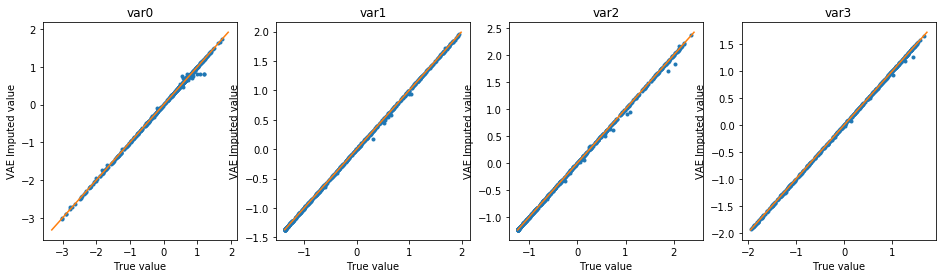

In [21]:
# plot imputation results for each variable:
fig_h, subplot_grid = plt.subplots(nrows=1, ncols=4,  figsize=(16,4)) #, sharex=True, sharey=True, squeeze=False)
#min_i = np.min(Xdata[:,var_i])
#max_i = np.max(Xdata[:,var_i])
for i in range(4):
    #print(i)
    var_i = i 
    min_i = np.min(Xdata[:,var_i])
    max_i = np.max(Xdata[:,var_i])
    subplot_grid[i].plot(Xdata[NanIndex[0][np.where(NanIndex[1]==var_i)],var_i],X_impute[NanIndex[0][np.where(NanIndex[1]==var_i)],var_i],'.')
    subplot_grid[i].plot([min_i, max_i], [min_i, max_i]) #the line
    subplot_grid[i].set_xlabel('True value')
    subplot_grid[i].set_ylabel('VAE Imputed value')
    subplot_grid[i].set_title('var' + str(i))
fig_h.savefig("imputation_res_x_heavy.png", dpi=100)